## Import Modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import nums_from_string
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras import layers, models

##  Loading and  Label Extraction

In [4]:
def get_redshifts(filelist, number_of_images = 57720, rot = False, flip = False):
    num_string = nums_from_string.get_nums(filelist[0])
    if len(num_string) == 2:
        z = num_string[1]
    if len(num_string) == 3:
        z = num_string[1]*10**(num_string[2])
    if rot:
        for j in [1,2,3]:
            z = np.append(z, nums_from_string.get_nums(filelist[0])[1])
    if flip:
        z = np.append(z, nums_from_string.get_nums(filelist[0])[1])
        if rot:
            for j in [1,2,3]:
                z = np.append(z, nums_from_string.get_nums(filelist[0])[1])
    for i in filelist[1:number_of_images]:
        z = np.append(z, nums_from_string.get_nums(i)[1])
        if rot:
            for j in [1,2,3]:
                z = np.append(z, nums_from_string.get_nums(i)[1])
        if flip:
            z = np.append(z, nums_from_string.get_nums(i)[1])
            if rot:
                for j in [1,2,3]:
                    z = np.append(z, nums_from_string.get_nums(i)[1])              
    return z

In [ ]:
def myget_images(filelist, number_of_images = 57720, rot = False, flip = False):
    _ = np.expand_dims(mpimg.imread(filelist[0]).astype(float), axis = 0)
    jpgs = _
    
    for i in filelist[1:number_of_images]:
        _ = np.expand_dims(mpimg.imread(i), axis = 0)
        jpgs = np.concatenate((jpgs, _))
        
    z = get_redshifts(filelist, number_of_images, rot, flip)
    return jpgs, z

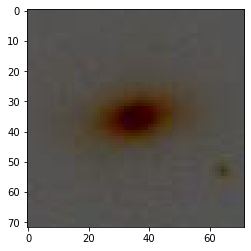

In [88]:
mytest_image = 'sdss_images/301829438239172608_z_0.0616709.jpg'
plt.imshow(mpimg.imread(mytest_image))

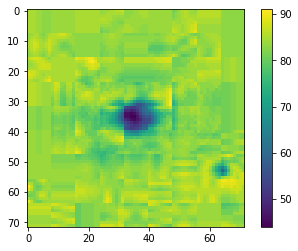

In [202]:
plt.imshow(mpimg.imread(mytest_image)[:,:,0])
plt.colorbar()

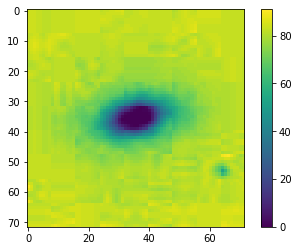

In [203]:
plt.imshow(mpimg.imread(mytest_image)[:,:,1])
plt.colorbar()

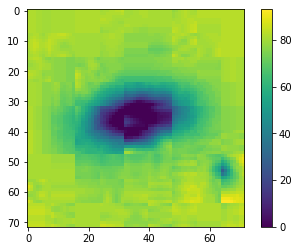

In [204]:
plt.imshow(mpimg.imread(mytest_image)[:,:,2])
plt.colorbar()

In [95]:
np.expand_dims(mpimg.imread(mytest_image).astype(float), axis = 0).shape

(1, 72, 72, 3)

In [153]:
def get_images(filelist, number_of_images = 57720, rot = False, flip = False):
    _ = np.expand_dims(mpimg.imread(filelist[0]).astype(float), axis = 0)
    jpgs = _
    
    if rot:
        for j in [1,2,3]:
            _ = np.rot90(_, j, axes = (1,2))
            jpgs = np.concatenate((jpgs, _))
                
    if flip:
        _ = np.flip(_, 1)
        jpgs = np.concatenate((jpgs, _))
        if rot:
            for j in [1,2,3]:
                _ = np.rot90(_, j, axes = (1,2))
                jpgs = np.concatenate((jpgs, _))
                
    x=1
    y=5
    
    for i in filelist[1:number_of_images]:
        
        if x % (len(filelist)/20) == 0:
            print(y)
            y = y+5
        
        _ = np.expand_dims(mpimg.imread(i), axis = 0)
        jpgs = np.concatenate((jpgs, _))
        
        if rot:
            for j in [1,2,3]:
                _ = np.rot90(_, j, axes = (1,2))
                jpgs = np.concatenate((jpgs, _))
                
        if flip:
            _ = np.flip(_, 1)
            jpgs = np.concatenate((jpgs, _))
            if rot:
                for j in [1,2,3]:
                    _ = np.rot90(_, j, axes = (1,2))
                    jpgs = np.concatenate((jpgs, _))
        x = x+1
                    
    z = get_redshifts(filelist, number_of_images, rot, flip)
    return jpgs, z

## Optional Cropping and Shuffling Parameters 

In [16]:
def center_crop(a, width = 60):
    x = int(36-width/2)
    y = int(36+width/2)
    a = a[:,x:y,x:y,:]
    return a

def random_crop(a, width = 60):
    m = width/2
    n = 72 - width/2
    b = np.zeros((len(a), width, width, 3))
    for i in np.arange(len(b)):
        z = np.random.randint(m,n)
        x = int(z-width/2)
        y = int(z+width/2)
        b[i] = a[i,x:y,x:y,:]
    return b

def crop(a, width = 60):
    m = width//2
    n = 72 - width//2
    b = np.zeros((len(a), width, width, 3))
    c = np.zeros((width, width))
    for i in np.arange(len(a)):
        c = np.sum(a[i], axis = 2)
        ind = list(np.unravel_index(np.argmax(c, axis=None), c.shape))
       	for j in [0,1]:
            if ind[j] < m:
                ind[j] = m
            elif ind[j] > n:
                ind[j] = n
        x0 = ind[0]-m
        x1 = x0+width
        y0 = ind[1]-m
        y1 = y0+width
        b[i] = a[i,x0:x1,y0:y1,:]
    return b

In [136]:
def unison_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def rescaling(data):
    for i in np.arange(len(data)):
        data[i] = data[i]/np.amax(data[i])
    return data

def reshape(a, width):
    length = len(a)
    return np.reshape(a, (length,(width**2)*3))

## Train/Test Split 

In [151]:
def data_prep(num = 57720, width = 72, train_split= 0.6, val_split = 0.2, rot = False, flip = False, shuf = False, ran_crop = False, cen_crop = False):
    # np.random.seed(1684)
    filelist = glob.glob("sdss_images/*.jpg")
    print('Reading Data')
    dat, tar = get_images(filelist, num, rot, flip)
    print('Rescaling')
    dat = rescaling(dat)
    print('Cropping images')
    if ran_crop:
        dat = random_crop(dat, width)
    elif cen_crop:
        dat = center_crop(dat, width)   
    else:
        dat = crop(dat, width)
    if shuf:
        dat, tar = unison_shuffle(dat, tar)
    dat = reshape(dat,width)
    print('Spliting Data')
    if shuf:
        train, val, testtest, train_tar, val_tar, test_tar = split(dat, tar, train_split, val_split, shuffle = False)
    else:
        train, val, testtest, train_tar, val_tar, test_tar = split(dat, tar, train_split, val_split)
    return train, val, testtest, train_tar, val_tar, test_tar

In [147]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_value = predictions_array[i][0]
    if predicted_value == true_label: # change this to how close it is!
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("Predicted redshift {:.7f} (true value {}))".format(predicted_value,
                                         true_label),
                                         color=color)

In [154]:
# work with 500 for now to not oversaturate everything
train, val, test, train_tar, val_tar, test_tar = data_prep(num = 500, width = 60)
print(np.shape(train), np.shape(val), np.shape(test), np.shape(train_tar), np.shape(val_tar), np.shape(test_tar))

Reading Data
Rescaling
Cropping images
Spliting Data
(299, 10800) (101, 10800) (100, 10800) (299,) (101,) (100,)


In [61]:
train.shape

(299, 10800)

In [46]:
np.max(test_tar)

2.29181

In [41]:
test_tar

array([0.202994 , 0.0806183, 0.111436 , 0.0556128, 0.0953551, 0.127988 ,
       0.0142164, 0.149271 , 0.104828 , 0.206495 , 0.0993268, 0.122522 ,
       0.148857 , 0.241398 , 0.102498 , 0.162909 , 0.266861 , 0.155857 ,
       0.0761477, 0.146582 , 0.0462295, 0.073603 , 0.432796 , 0.0494687,
       0.0554923, 0.198808 , 0.0497526, 0.0654706, 0.0872169, 0.193284 ,
       9.70722  , 0.0348964, 0.102011 , 0.204296 , 0.492943 , 0.138761 ,
       0.0997023, 0.0459531, 0.505431 , 0.372977 , 0.149731 , 0.115317 ,
       0.114467 , 0.102789 , 0.137915 , 0.0722077, 0.088924 , 0.0751862,
       0.530769 , 0.331039 , 0.133099 , 0.136213 , 0.0797516, 0.0528979,
       0.22416  , 0.163583 , 0.0835386, 0.0915407, 0.220893 , 0.160986 ,
       0.314458 , 0.101227 , 0.171559 , 0.0756004, 0.134936 , 0.179541 ,
       0.215823 , 0.0578115, 0.171776 , 0.0887756, 0.340599 , 0.133603 ,
       0.157182 , 0.0887728, 0.109921 , 0.0590847, 0.0474688, 0.0635013,
       0.179801 , 0.245329 , 0.101232 , 0.198425 , 

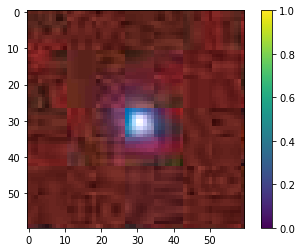

In [99]:
plt.figure()
plt.imshow(test[15])
plt.colorbar()
plt.grid(False)
plt.show()

# ANN 

[source](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/)

In [193]:
model_ann = tf.keras.Sequential([
    #tf.keras.layers.Flatten(input_shape = (10080,)),
    #tf.keras.layers.Flatten(input_shape = (72,72,3)),
    #tf.keras.layers.Dense(15552, activation='tanh'),
    tf.keras.layers.Dense(2000, activation='tanh'),
    tf.keras.layers.Dense(500, activation='tanh'),
    tf.keras.layers.Dense(500, activation='tanh'),
    tf.keras.layers.Dense(250, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1)
])
model_ann.compile(optimizer='adam',
             loss= 'mse')
model_ann.fit(train, train_tar, batch_size=32, epochs=50)

Epoch 1/50
10/10 [==============================] - 6s 569ms/step - loss: 4.2359
Epoch 2/50
10/10 [==============================] - 6s 580ms/step - loss: 0.3378
Epoch 3/50
10/10 [==============================] - 6s 599ms/step - loss: 0.3177
Epoch 4/50
10/10 [==============================] - 6s 565ms/step - loss: 0.3208
Epoch 5/50
10/10 [==============================] - 6s 579ms/step - loss: 0.3178
Epoch 6/50
10/10 [==============================] - 5s 547ms/step - loss: 0.3199
Epoch 7/50
10/10 [==============================] - 5s 536ms/step - loss: 0.3225
Epoch 8/50
10/10 [==============================] - 5s 533ms/step - loss: 0.3288
Epoch 9/50
10/10 [==============================] - 5s 502ms/step - loss: 0.3225
Epoch 10/50
10/10 [==============================] - 5s 485ms/step - loss: 0.3191
Epoch 11/50
10/10 [==============================] - 5s 509ms/step - loss: 0.3171
Epoch 12/50
10/10 [==============================] - 5s 502ms/step - loss: 0.3205
Epoch 13/50
10/10 [======

In [196]:
error = model_ann.evaluate(val, val_tar, verbose=2)
error

4/4 - 1s - loss: 0.0101


0.010103040374815464

In [201]:
predictions = model_ann.predict(test)
predictions

array([[0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977157],
       [0.16977157],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.16977158],
       [0.169

In [199]:
# The network is predicting nearly the same value for all neurons, independent of number of neurons or depth.
# How close is this value to the average redshift?

print(np.mean(train_tar),np.mean(test_tar))

0.18529357417725756 0.145188683


In [191]:
test_tar[5]

0.135357

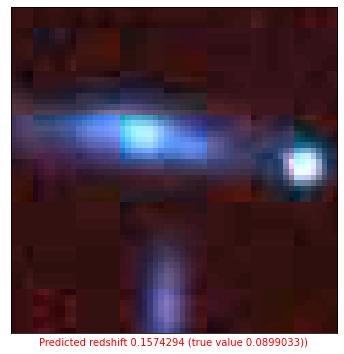

In [56]:
i = 30
plt.figure(figsize=(10,6))
plot_image(i, predictions, test_tar, test)
plt.show()

In [126]:
test_tar

array([0.202994 , 0.0806183, 0.111436 , 0.0556128, 0.0953551, 0.127988 ,
       0.0142164, 0.149271 , 0.104828 , 0.206495 , 0.0993268, 0.122522 ,
       0.148857 , 0.241398 , 0.102498 , 0.162909 , 0.266861 , 0.155857 ,
       0.0761477, 0.146582 , 0.0462295, 0.073603 , 0.432796 , 0.0494687,
       0.0554923, 0.198808 , 0.0497526, 0.0654706, 0.0872169, 0.193284 ,
       9.70722  , 0.0348964, 0.102011 , 0.204296 , 0.492943 , 0.138761 ,
       0.0997023, 0.0459531, 0.505431 , 0.372977 , 0.149731 , 0.115317 ,
       0.114467 , 0.102789 , 0.137915 , 0.0722077, 0.088924 , 0.0751862,
       0.530769 , 0.331039 , 0.133099 , 0.136213 , 0.0797516, 0.0528979,
       0.22416  , 0.163583 , 0.0835386, 0.0915407, 0.220893 , 0.160986 ,
       0.314458 , 0.101227 , 0.171559 , 0.0756004, 0.134936 , 0.179541 ,
       0.215823 , 0.0578115, 0.171776 , 0.0887756, 0.340599 , 0.133603 ,
       0.157182 , 0.0887728, 0.109921 , 0.0590847, 0.0474688, 0.0635013,
       0.179801 , 0.245329 , 0.101232 , 0.198425 , 

This won't work because this is a classifier!

In [73]:
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(32, (3,3), activation='tanh'))
#model_cnn.add(layers.Conv2D(32, (3,3), activation='tanh', input_shape=(60,60,3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3,3), activation='tanh'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3,3), activation='tanh'))
#model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='tanh'))
model_cnn.add(layers.Dense(10))
model_cnn.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [69]:
model_cnn.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  #loss='mean_squared_error',
             metrics=['mse'])

history = model_cnn.fit(train, train_tar, epochs=5,
                    validation_data=(test, test_tar))

Epoch 1/5


ValueError: in user code:

    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_3 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: [None, 10800]


In [39]:
test_loss, test_acc = model_cnn.evaluate(test, test_tar, verbose=2)
print('\nTest accuracy:', test_acc)

4/4 - 0s - loss: 0.1229 - accuracy: 0.0000e+00

Test accuracy: 0.0


In [37]:
np.argmax(predictions[8])

0

In [ ]:
i = 69
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], test_labels)
plt.show()

In [62]:
np.max(train_tar)

9.70722

## Cropping, Scaling, and Zooming 

# Run through Pipelines

## Training/Test split 

## Random Forests 

[code template](https://www.astroml.org/book_figures/chapter9/fig_photoz_forest.html)

## Convolutional Neural Network 

## Boosted Decision Trees 

[code template](http://www.astroml.org/book_figures/chapter9/fig_photoz_tree.html)

# Validation 

## Learning Curves, Early Stopping 

# Statistics 